# Probe Validation Analysis

This notebook explores the results of validating that temporal probes detect **semantic** features (not just lexical keywords).

**Experiment**: Train probes on explicit (keyword-rich) data, test on implicit (semantic-only) data.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load results
with open('../results/probe_validation_results.json') as f:
    results = json.load(f)

print("Experiment:", results['metadata']['experiment'])
print("Timestamp:", results['metadata']['timestamp'])
print("Git commit:", results['metadata']['git_commit'])

Experiment: probe_semantic_validation
Timestamp: 2025-12-03T17:55:00+00:00
Git commit: 01802b8ed5bd48e0b6661ff627d7aff7c30e74dd


## Reproducibility Info

In [2]:
print("=" * 50)
print("REPRODUCIBILITY METADATA")
print("=" * 50)
print(f"Git commit: {results['metadata']['git_commit']}")
print(f"Git branch: {results['metadata']['git_branch']}")
print(f"Uncommitted changes: {results['metadata']['git_dirty']}")
print(f"Random seed: {results['metadata']['random_seed']}")
print()
print("Package versions:")
for pkg, ver in results['metadata']['package_versions'].items():
    print(f"  {pkg}: {ver}")
print()
print("Compute:")
for k, v in results['metadata']['compute'].items():
    print(f"  {k}: {v}")
print()
print("Dataset hashes (SHA256):")
for name, info in results['datasets'].items():
    print(f"  {info['path']}: {info['sha256'][:16]}...")

REPRODUCIBILITY METADATA
Git commit: 01802b8ed5bd48e0b6661ff627d7aff7c30e74dd
Git branch: main
Uncommitted changes: True
Random seed: 42

Package versions:
  torch: 2.7.0+cu128
  transformers: 4.47.1
  sklearn: 1.6.0
  numpy: 2.2.1

Compute:
  platform: GCP
  instance_type: n1-standard-4
  gpu: nvidia-tesla-t4
  zone: us-central1-b

Dataset hashes (SHA256):
  data/raw/temporal_scope_caa.json: 8c30b3168b61cbce...
  data/raw/temporal_scope_implicit.json: 8d34212a4cb19f66...


## Results Overview

In [3]:
# Create DataFrame from results
explicit_df = pd.DataFrame(results['explicit_results'])
implicit_df = pd.DataFrame(results['implicit_results'])

# Merge
df = explicit_df.merge(implicit_df, on='layer')
df['gap'] = df['test_acc'] - df['implicit_acc']
df['status'] = df['implicit_acc'].apply(
    lambda x: 'SEMANTIC' if x >= 0.70 else ('WEAK' if x >= 0.55 else 'LEXICAL')
)

df

,layer,cv_mean,cv_std,test_acc,implicit_acc,gap,status
0,0,0.7500,0.131101,0.80,0.66,0.14,WEAK
1,1,0.7250,0.179409,0.75,0.68,0.07,WEAK
2,2,0.6875,0.162980,0.75,0.66,0.09,WEAK
3,3,0.7250,0.179409,0.85,0.65,0.20,WEAK
4,4,0.7375,0.133463,0.80,0.64,0.16,WEAK
5,5,0.7750,0.175000,0.85,0.66,0.19,WEAK
6,6,0.7500,0.158114,0.90,0.67,0.23,WEAK
7,7,0.7750,0.140312,0.85,0.73,0.12,SEMANTIC
8,8,0.8000,0.155121,0.90,0.77,0.13,SEMANTIC
9,9,0.8000,0.091856,0.90,0.78,0.12,SEMANTIC


## Visualization: Explicit vs Implicit Accuracy by Layer

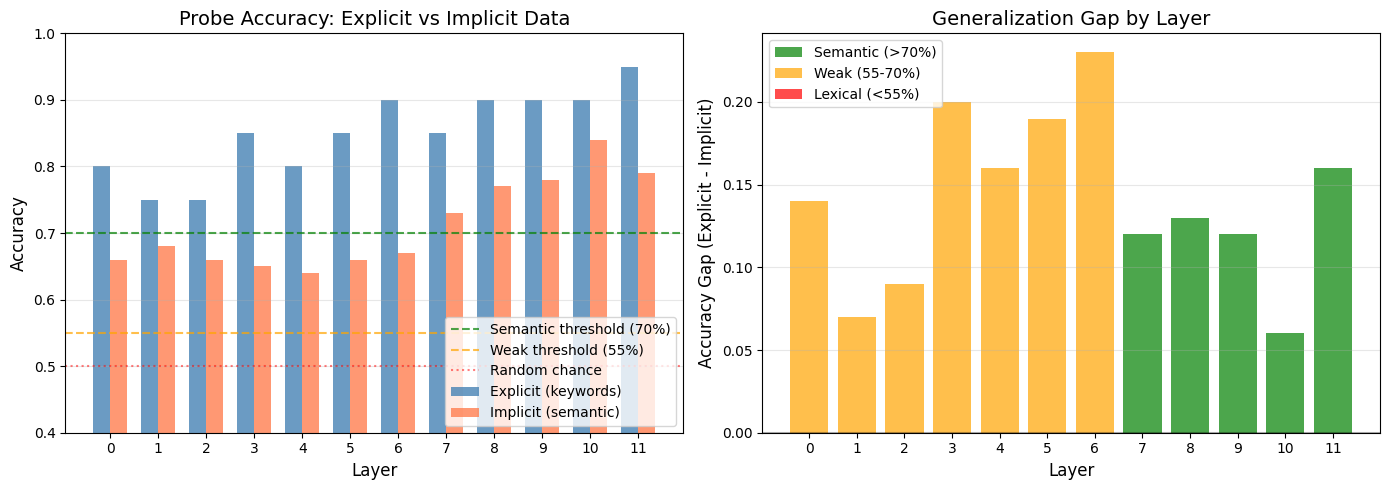


Figure saved to results/figures/probe_validation.png


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
ax1 = axes[0]
x = df['layer']
width = 0.35

bars1 = ax1.bar(x - width/2, df['test_acc'], width, label='Explicit (keywords)', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, df['implicit_acc'], width, label='Implicit (semantic)', color='coral', alpha=0.8)

ax1.axhline(y=0.70, color='green', linestyle='--', alpha=0.7, label='Semantic threshold (70%)')
ax1.axhline(y=0.55, color='orange', linestyle='--', alpha=0.7, label='Weak threshold (55%)')
ax1.axhline(y=0.50, color='red', linestyle=':', alpha=0.5, label='Random chance')

ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Probe Accuracy: Explicit vs Implicit Data', fontsize=14)
ax1.set_xticks(x)
ax1.set_ylim(0.4, 1.0)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Gap between explicit and implicit
ax2 = axes[1]
colors = ['green' if s == 'SEMANTIC' else ('orange' if s == 'WEAK' else 'red') for s in df['status']]
ax2.bar(x, df['gap'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Accuracy Gap (Explicit - Implicit)', fontsize=12)
ax2.set_title('Generalization Gap by Layer', fontsize=14)
ax2.set_xticks(x)
ax2.grid(axis='y', alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Semantic (>70%)'),
    Patch(facecolor='orange', alpha=0.7, label='Weak (55-70%)'),
    Patch(facecolor='red', alpha=0.7, label='Lexical (<55%)')
]
ax2.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig('../results/figures/probe_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to results/figures/probe_validation.png")

## Layer-by-Layer Analysis

In [5]:
print("=" * 70)
print("LAYER-BY-LAYER ANALYSIS")
print("=" * 70)
print()

for _, row in df.iterrows():
    layer = int(row['layer'])
    explicit = row['test_acc']
    implicit = row['implicit_acc']
    gap = row['gap']
    status = row['status']
    
    icon = '✓' if status == 'SEMANTIC' else ('○' if status == 'WEAK' else '✗')
    
    print(f"Layer {layer:2d}: {icon} {status:8s} | Explicit: {explicit:.1%} | Implicit: {implicit:.1%} | Gap: {gap:+.1%}")

LAYER-BY-LAYER ANALYSIS

Layer  0: ○ WEAK     | Explicit: 80.0% | Implicit: 66.0% | Gap: +14.0%
Layer  1: ○ WEAK     | Explicit: 75.0% | Implicit: 68.0% | Gap: +7.0%
Layer  2: ○ WEAK     | Explicit: 75.0% | Implicit: 66.0% | Gap: +9.0%
Layer  3: ○ WEAK     | Explicit: 85.0% | Implicit: 65.0% | Gap: +20.0%
Layer  4: ○ WEAK     | Explicit: 80.0% | Implicit: 64.0% | Gap: +16.0%
Layer  5: ○ WEAK     | Explicit: 85.0% | Implicit: 66.0% | Gap: +19.0%
Layer  6: ○ WEAK     | Explicit: 90.0% | Implicit: 67.0% | Gap: +23.0%
Layer  7: ✓ SEMANTIC | Explicit: 85.0% | Implicit: 73.0% | Gap: +12.0%
Layer  8: ✓ SEMANTIC | Explicit: 90.0% | Implicit: 77.0% | Gap: +13.0%
Layer  9: ✓ SEMANTIC | Explicit: 90.0% | Implicit: 78.0% | Gap: +12.0%
Layer 10: ✓ SEMANTIC | Explicit: 90.0% | Implicit: 84.0% | Gap: +6.0%
Layer 11: ✓ SEMANTIC | Explicit: 95.0% | Implicit: 79.0% | Gap: +16.0%


## Summary Statistics

In [6]:
summary = results['summary']

print("=" * 50)
print("VALIDATION SUMMARY")
print("=" * 50)
print(f"Best semantic layer: {summary['best_semantic_layer']}")
print(f"Best implicit accuracy: {summary['best_implicit_accuracy']:.1%}")
print(f"Validation passed: {summary['validation_passed']}")
print()

# Statistics
semantic_layers = df[df['status'] == 'SEMANTIC']['layer'].tolist()
weak_layers = df[df['status'] == 'WEAK']['layer'].tolist()
lexical_layers = df[df['status'] == 'LEXICAL']['layer'].tolist()

print(f"Semantic layers (>70%): {semantic_layers}")
print(f"Weak layers (55-70%): {weak_layers}")
print(f"Lexical layers (<55%): {lexical_layers}")
print()

print(f"Mean explicit accuracy: {df['test_acc'].mean():.1%}")
print(f"Mean implicit accuracy: {df['implicit_acc'].mean():.1%}")
print(f"Mean generalization gap: {df['gap'].mean():.1%}")

VALIDATION SUMMARY
Best semantic layer: 10
Best implicit accuracy: 84.0%
Validation passed: True

Semantic layers (>70%): [7, 8, 9, 10, 11]
Weak layers (55-70%): [0, 1, 2, 3, 4, 5, 6]
Lexical layers (<55%): []

Mean explicit accuracy: 85.0%
Mean implicit accuracy: 71.1%
Mean generalization gap: 13.9%


## Interpretation

### Key Findings

1. **Late layers (7-11) encode semantic temporal features**
   - Accuracy remains >70% even without temporal keywords
   - Smaller generalization gap suggests robust encoding

2. **Early layers (0-6) are more keyword-dependent**
   - Larger gap between explicit and implicit accuracy
   - May rely more on lexical patterns

3. **Layer 10 is the best semantic layer**
   - 84% accuracy on implicit (semantic-only) data
   - Only 6% gap from explicit accuracy

### Implications for SPD

- Focus SPD decomposition on layers 7-11
- Layer 10 is the prime target for understanding temporal encoding
- Probes are validated as detecting genuine temporal semantics

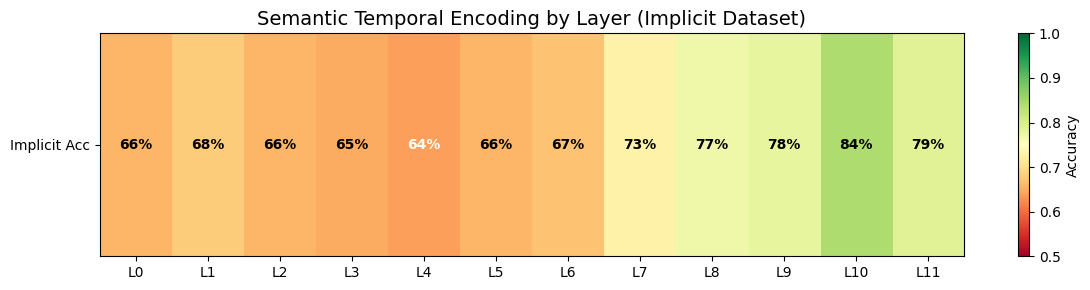

In [7]:
# Heatmap visualization
fig, ax = plt.subplots(figsize=(12, 3))

# Create heatmap data
heatmap_data = df[['implicit_acc']].T.values

im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)

# Labels
ax.set_xticks(range(12))
ax.set_xticklabels([f'L{i}' for i in range(12)])
ax.set_yticks([0])
ax.set_yticklabels(['Implicit Acc'])

# Add text annotations
for i, acc in enumerate(df['implicit_acc']):
    color = 'white' if acc < 0.65 else 'black'
    ax.text(i, 0, f'{acc:.0%}', ha='center', va='center', color=color, fontweight='bold')

ax.set_title('Semantic Temporal Encoding by Layer (Implicit Dataset)', fontsize=14)
plt.colorbar(im, ax=ax, label='Accuracy')

plt.tight_layout()
plt.savefig('../results/figures/probe_validation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## Cross-Validation Analysis

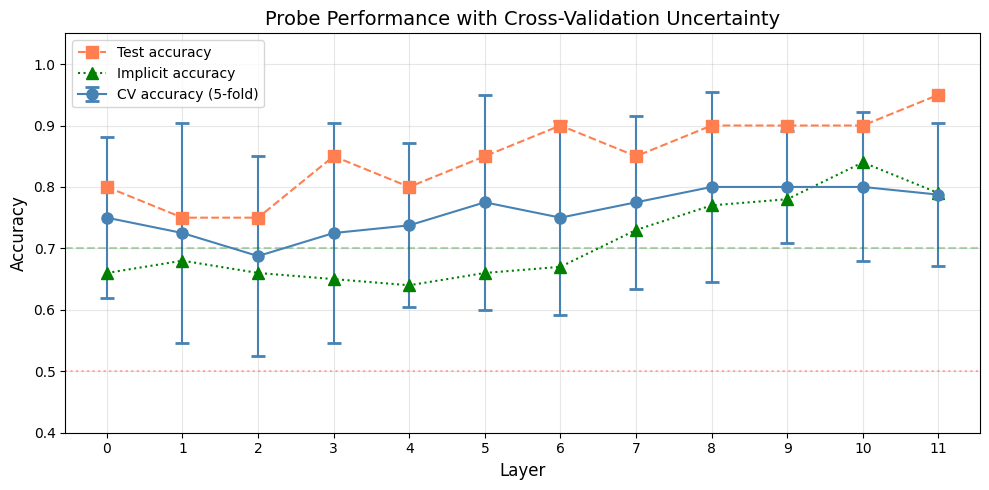


Note: Error bars show ±1 std from 5-fold cross-validation on explicit data


In [8]:
# Plot CV results with error bars
fig, ax = plt.subplots(figsize=(10, 5))

x = df['layer']
cv_mean = df['cv_mean']
cv_std = df['cv_std']

ax.errorbar(x, cv_mean, yerr=cv_std, fmt='o-', capsize=5, capthick=2, 
            color='steelblue', label='CV accuracy (5-fold)', markersize=8)
ax.plot(x, df['test_acc'], 's--', color='coral', label='Test accuracy', markersize=8)
ax.plot(x, df['implicit_acc'], '^:', color='green', label='Implicit accuracy', markersize=8)

ax.axhline(y=0.70, color='green', linestyle='--', alpha=0.3)
ax.axhline(y=0.50, color='red', linestyle=':', alpha=0.3)

ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Probe Performance with Cross-Validation Uncertainty', fontsize=14)
ax.set_xticks(x)
ax.set_ylim(0.4, 1.05)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Error bars show ±1 std from 5-fold cross-validation on explicit data")